## 1. Dataset Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv("training_set_pixel_size_and_HC.csv")
test_df  = pd.read_csv("test_set_pixel_size.csv")

print(train_df.head())
print(train_df.describe())
print(train_df.columns.tolist())


     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81
       pixel size(mm)  head circumference (mm)
count      999.000000               999.000000
mean         0.139846               174.383093
std          0.053005                65.282061
min          0.049415                44.300000
25%          0.108801               153.600000
50%          0.128357               174.060000
75%          0.157678               189.825000
max          0.393280               346.400000
['filename', 'pixel size(mm)', 'head circumference (mm)']


Missing values:
filename                   0
pixel size(mm)             0
head circumference (mm)    0
dtype: int64


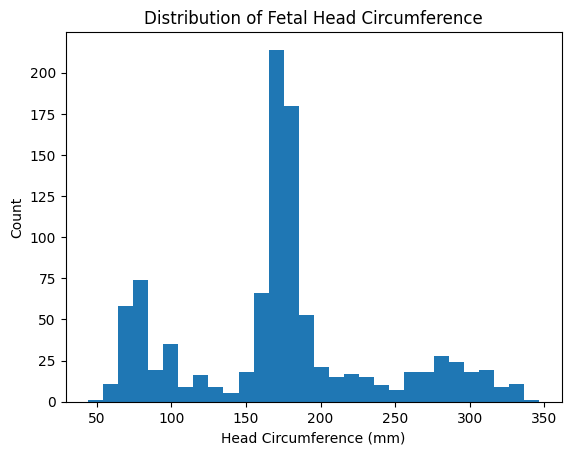

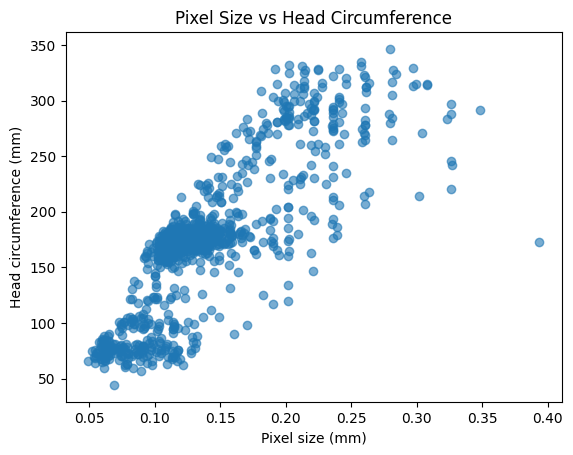

In [2]:
print("Missing values:")
print(train_df.isnull().sum())

plt.figure()
plt.hist(train_df['head circumference (mm)'], bins=30)
plt.xlabel("Head Circumference (mm)")
plt.ylabel("Count")
plt.title("Distribution of Fetal Head Circumference")
plt.show()

plt.figure()
plt.scatter(train_df['pixel size(mm)'], train_df['head circumference (mm)'], alpha=0.6)
plt.xlabel("Pixel size (mm)")
plt.ylabel("Head circumference (mm)")
plt.title("Pixel Size vs Head Circumference")
plt.show()


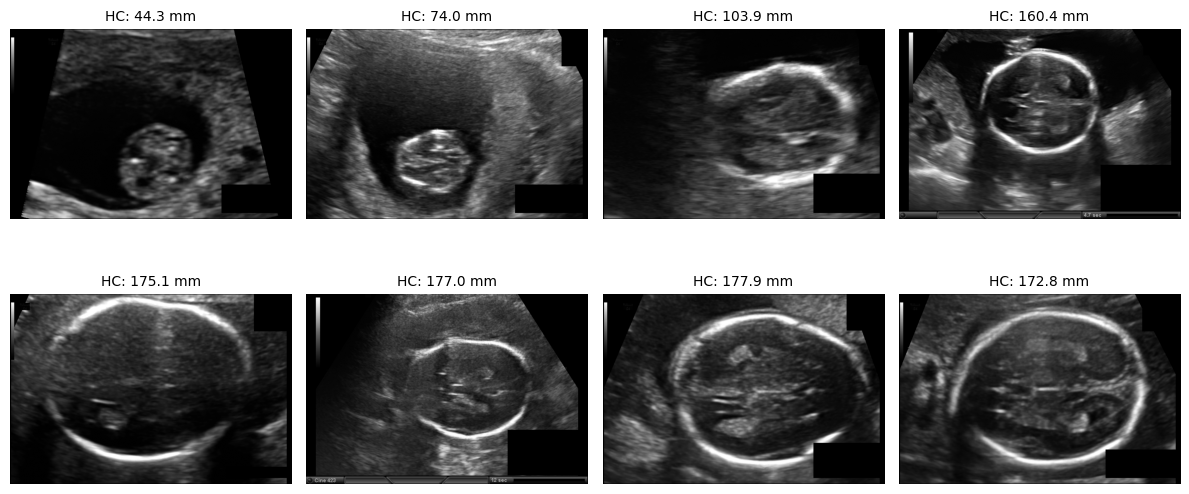

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

# Display sample training images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for i, ax in enumerate(axes):
    row = train_df.iloc[i * 100]
    filename = row["filename"]
    hc = row["head circumference (mm)"]

    img = Image.open(f"training_set/{filename}")
    ax.imshow(img, cmap="gray")
    ax.set_title(f"HC: {hc:.1f} mm", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


## 2. Baseline Regression

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

X = train_df[['pixel size(mm)']]
y = train_df['head circumference (mm)']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)

print("Baseline Linear Regression MAE:", mae)

Baseline Linear Regression MAE: 29.671482014914996


## 3. Clean Column Names

In [5]:
train_df.columns = train_df.columns.str.strip()
test_df.columns  = test_df.columns.str.strip()

## 4. Image Preprocessing

In [6]:
import cv2
import numpy as np

IMG_SIZE = 224

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img.reshape(IMG_SIZE, IMG_SIZE, 1)


## 5. Data Generator

In [7]:
from tensorflow.keras.utils import Sequence

class HCDataGenerator(Sequence):
    def __init__(self, df, image_dir, batch_size=16):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.batch_size = batch_size

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size]

        X, y = [], []

        for _, row in batch.iterrows():
            img_path = f"{self.image_dir}/{row['filename']}"
            img = load_image(img_path)

            X.append(img)
            y.append(row['head circumference (mm)'])

        return np.array(X), np.array(y)

## 6. Train / Validation Split

In [8]:
from sklearn.model_selection import train_test_split

train_df_split, val_df_split = train_test_split(
    train_df, test_size=0.2, random_state=42
)

train_gen = HCDataGenerator(train_df_split, "training_set", batch_size=4)
val_gen   = HCDataGenerator(val_df_split, "training_set", batch_size=4)

print("Train samples:", len(train_df_split))
print("Validation samples:", len(val_df_split))

Train samples: 799
Validation samples: 200


## 7. CNN Regression Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(224,224,1)),
    MaxPooling2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),

    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mae']
)

model.summary()


c:\Users\ngtru\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,513 (42.60 MB)

 Trainable params: 11,168,513 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Training

In [10]:
model.fit(train_gen, epochs=20)

Epoch 1/20


c:\Users\ngtru\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 223ms/step - loss: 70.4633 - mae: 70.4633
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 38.0035 - mae: 38.0035
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - loss: 32.9976 - mae: 32.9976
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - loss: 31.2640 - mae: 31.2640
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 52s 263ms/step - loss: 30.7686 - mae: 30.7686
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - loss: 27.4243 - mae: 27.4243
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 47s 236ms/step - loss: 25.9984 - mae: 25.9984
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 45s 225ms/step - loss: 23.1764 - mae: 23.1764
Epoch 9/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 212ms/step - loss: 23.0514 - mae: 23.0514
Epoch 10/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - loss: 18.6389 - mae: 18.6389
Epoch 11/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 232ms/step - loss: 19.8829 - mae: 19.8829
Epoch 12/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 46s 233ms/step - loss: